# Training pipeline for MFCC (train + save)

In [20]:
import sys
import os
from git_root import git_root

import numpy as np
import tensorflow as tf

from tensorflow.keras.optimizers import Adam

sys.path.append(git_root("utils"))
from utils import load_params

from fetch_data import fetch_data_local
from fetch_data import to_numpy_arrays, prepare_tf_dataset

sys.path.append(git_root("models"))
from MFCC_model import setup_model

from validation_utils import plot_history

In [21]:
print(tf.__version__)

2.0.0


In [22]:
params = load_params()

In [23]:
train = fetch_data_local(map_type="mfcc", train=True)
test = fetch_data_local(map_type="mfcc", train=False)

Fetching: data_mfcc_train.json
Fetching: data_mfcc_test.json


In [24]:
print("train")
print(train.shape)
print("test")
print(test.shape)

train
(900, 3)
test
(100, 3)


In [25]:
np.array(train.loc[0,'maps']).shape

(30, 40, 50)

In [26]:
len(train.iloc[0, 1])

30

In [27]:
train = to_numpy_arrays(train, mfcc=True)
test = to_numpy_arrays(test, mfcc=True)

In [28]:
print("train")
print(len(train[0]))
print(len(train[1]))
print("test")
print(len(test[0]))
print(len(test[1]))

train
900
900
test
100
100


In [29]:
train_sample_unstacked = []
train_label_unstacked = []

for j in range(len(train[0])):
    train_sample_unstacked += [train[0][j][:,:,i].reshape(40,50,1) for i in range(train[0][0].shape[-1])]

for i in range(len(train[1])):
    train_label_unstacked += [train[1][i]]*(train[0][0].shape[-1])

In [30]:
test_sample_unstacked = []
test_label_unstacked = []

for j in range(len(test[0])):
    test_sample_unstacked += [test[0][j][:,:,i].reshape(40,50,1) for i in range(test[0][0].shape[-1])]

for i in range(len(test[1])):
    test_label_unstacked += [test[1][i]]*(test[0][0].shape[-1])

In [31]:
train = prepare_tf_dataset(train_sample_unstacked, train_label_unstacked)
test = prepare_tf_dataset(test_sample_unstacked, test_label_unstacked)

In [32]:
tr_sample_batch, tr_label_batch = next(iter(train))
te_sample_batch, te_label_batch = next(iter(test))
print("train")
print(tr_sample_batch.shape, tr_label_batch.shape)
print("test")
print(te_sample_batch.shape, te_label_batch.shape)

train
(32, 40, 50, 1) (32,)
test
(32, 40, 50, 1) (32,)


In [33]:
#We load the model
net = setup_model()
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 31, 41, 12)        1212      
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 7, 10, 12)         0         
_________________________________________________________________
affine (AffineScalar)        (None, 7, 10, 12)         2         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 8, 12)          1308      
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                130       
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
____________________________________________________

In [34]:
net.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = net.fit(train, epochs=250, validation_data=test)

Epoch 1/250
844/844 [==============================] - 22s 26ms/step - loss: 2.3060 - accuracy: 0.1737 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/250
844/844 [==============================] - 19s 22ms/step - loss: 2.2723 - accuracy: 0.1499 - val_loss: 2.2483 - val_accuracy: 0.1473
Epoch 3/250
844/844 [==============================] - 19s 22ms/step - loss: 2.2551 - accuracy: 0.1322 - val_loss: 2.2371 - val_accuracy: 0.1433
Epoch 4/250
844/844 [==============================] - 18s 22ms/step - loss: 2.2529 - accuracy: 0.1210 - val_loss: 2.2316 - val_accuracy: 0.1493
Epoch 5/250
844/844 [==============================] - 18s 21ms/step - loss: 2.2433 - accuracy: 0.1244 - val_loss: 2.2337 - val_accuracy: 0.1470
Epoch 6/250
844/844 [==============================] - 18s 21ms/step - loss: 2.2394 - accuracy: 0.1278 - val_loss: 2.2332 - val_accuracy: 0.1417
Epoch 7/250
844/844 [==============================] - 18s 21ms/step - loss: 2.2389 - accuracy: 0.1176 - val_loss: 2.2243 

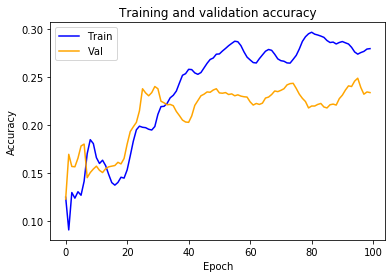

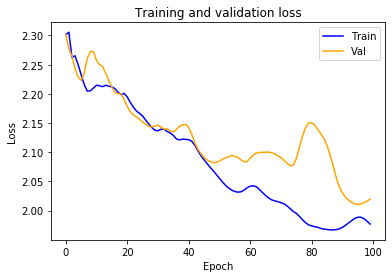

In [17]:
plot_history(history)

In [18]:
print(f"Final validation accuracy is: {history.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.234


In [19]:
file_path = git_root("models", "saved_models", "mfcc.h5")
net.save(file_path)